In [1]:
# EXECUTING THE FOLLOWING WILL INSTALL GLOBAL DEPENDENCIES ON YOUR SYSTEM.
# ONLY RUN FOR GOOGLE COLAB INSTANCES, ETC.
# Installs Pyomo (modeling language) and IPOPT (solver). See http://www.pyomo.org/ and https://coin-or.github.io/Ipopt/.

# !pip install pyomo
# !wget -N -q "https://matematica.unipv.it/gualandi/solvers/ipopt-linux64.zip"
# !unzip -o -q ipopt-linux64

from pyomo.environ import (
    SolverFactory,
    AbstractModel,
    Param,
    Set,
    Var,
    Objective,
    Constraint,
)
from pyomo.core import NonNegativeIntegers, PositiveReals, Any, NonNegativeReals  # type: ignore
from utils import get_mean

import matplotlib.pyplot as plt
import pandas as pd

solver = SolverFactory("ipopt")

### Reservoir Stats

- Name: Curve Reservoir
- Coordinates: $36.33385606273248, -111.6578894846542$ (latitude, longitude)
- Perimeter: $699.69$ m
- Area: $19,991.22$ m\*\*2
- Elevation: $1,815$ m


In [2]:
model = AbstractModel()

# Indices input parameters
model.T_intervals = Set(domain=NonNegativeIntegers)  # Time intervals
model.T_points = Set(
    domain=NonNegativeIntegers
)  # Time points, TODO: assert that this is [...T_intervals, 1]

# Constant input parameters
model.c1 = Param(within=PositiveReals, mutable=False)  # Scalar constant c1 for volume
model.c2 = Param(within=PositiveReals, mutable=False)  # Scalar constant c2 for volume
model.A_c = Param(within=PositiveReals, mutable=False)  # Catchment area (m^2)
model.S_max = Param(
    within=PositiveReals, mutable=False
)  # Maximum storage capacity (m^3). TODO: Remove in favor of calculating from max surface area.
model.A_max = Param(
    within=PositiveReals, mutable=False
)  # Maximum free surface area (m^2)
model.Q_max = Param(
    within=NonNegativeReals, mutable=False
)  # Upper limit for pumping rate (m^3 / time)
model.E_coeff = Param(within=PositiveReals, mutable=False)  # Evaporation coefficient

# Time-varying input parameters
model.P = Param(model.T_intervals, within=NonNegativeReals)  # Precipitation (m)
model.E_pan = Param(
    model.T_intervals, within=NonNegativeReals
)  # Pan evaporation rate (m). TODO: Reduce to a constant across all time.

# Dynamics-invariant Parameters
model.R = Param(
    model.T_intervals,
    default=lambda model, t: model.A_c * model.P[t],
    within=NonNegativeReals,
)

# Optimizable Variables
model.S = Var(model.T_points, domain=NonNegativeReals)  # Storage (m^3)
model.A = Var(model.T_points, domain=NonNegativeReals)  # Surface area (m^2)

model.E = Var(model.T_intervals, domain=NonNegativeReals)  # Evaporation (m^3)
model.Q = Var(model.T_intervals, domain=NonNegativeReals)  # Pumping (m^3)
# TODO: Model overflow as a binary conditional that is S_max - (S[t] + R[t] - E[t] - Q[t]), or 0 otherwise. This redundantly enforces S[t] <= S_max.
model.W = Var(model.T_intervals, domain=NonNegativeReals)  # Overflow (m^3)

# Objective
model.min_overflow = Objective(
    expr=lambda model: sum(model.W[t] for t in model.T_intervals)
)

# Constraints
model.upper_S = Constraint(
    model.T_points, rule=lambda model, t: model.S[t] <= model.S_max
)  # Upper-bound volume

model.upper_A = Constraint(
    model.T_points, rule=lambda model, t: model.A[t] <= model.A_max
)  # Upper-bound surface area

model.upper_Q = Constraint(
    model.T_intervals, rule=lambda model, t: model.Q[t] <= model.Q_max
)  # Upper-bound pumping

model.evaporation = Constraint(
    model.T_intervals,
    rule=lambda model, t: model.E[t]
    == model.E_coeff * model.E_pan[t] * (model.A[t] + model.A[t + 1]) / 2,
)  # Calculate evaporation (m^3)

model.storage = Constraint(
    model.T_points,
    rule=lambda model, t: model.S[t] == model.c1 * (0.000001 + model.A[t]) ** model.c2,
)  # Calculate volume (m^3)

model.dynamics = Constraint(
    model.T_intervals,
    rule=lambda model, t: model.S[t + 1]
    == model.S[t] + model.R[t] - model.E[t] - model.Q[t] - model.W[t],
)

# model.boundary = Constraint(
#     model.T_intervals,
#     rule=lambda model: model.c1 * (0.000000001 + model.A[7]) ** model.c2,
# )

In [3]:
# Obtain average monthly precipitation (mm/hour)
# pga_df = pd.read_csv(
#     "Water Optimization/dynamics_model/PGA_1973_2005.csv",
#     usecols=["valid", "p01i"],
#     header=0,
#     dtype={
#         "valid": "string",  # Datetime. Consider "datetime64[ns, UTC]"
#         "p01i": "Float32",  # Precipitation in last hr (mm)
#     },
# )

# pga_df["valid"] = pd.to_datetime(pga_df["valid"], utc=True).dt.tz_localize(
#     None
# )  # Remove timezone information
# pga_df = pga_df.convert_dtypes()
# pga_df = pga_df.dropna()

# PRECIP_RATE = get_mean(pga_df, "valid", ["p01i"], "M").groupby(["month"]).mean()["p01i"]
PRECIP_RATE = [0.55, 0.51, 0.59, 0.28, 0.31, 0.16, 0.67, 0.71, 0.98, 0.87, 0.43, 0.31]
PRECIP_RATE = [r * 2.54 / 100 for r in PRECIP_RATE]

# Pan evporation rate (in/month)
pan_m_df = pd.DataFrame(
    {
        "month": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
        "evap": [
            0.00,
            2.60,
            5.84,
            8.27,
            10.72,
            12.86,
            13.06,
            11.38,
            8.42,
            5.13,
            2.29,
            0.00,
        ],
    }
)

ELEVATION = 1815  # (m)
LATITUDE = 36.33385606273248

PAN_COEFF = 0.8
PAN_EVAP_RATE = (0.0254 * pan_m_df["evap"]).to_list()  # in/month -> m/month (m)

C1, C2 = (
    1.4534,
    1.1919,
)  # 30.684, 0.978  # Lehner, et al. (Global reservoir and dam database)
CATCHMENT_AREA = 10000  # 19991.22  # (m^2), from loading GEOJSON to http://geojson.io/
MAX_SURFACE_AREA = 100  # 482970.15  # (m^2)
MAX_VOLUME = C1 * MAX_SURFACE_AREA**C2  # (m^3)
print(MAX_VOLUME)

351.7103557478217


In [4]:
num_intervals = 12
interval_indices = list(range(num_intervals))  # [0, ..., num_intervals - 1]
points_indices = list(
    range(num_intervals + 1)
)  # [0, ..., num_intervals - 1, num_intervals]

data = {
    None: {
        "T_intervals": {None: interval_indices},
        "T_points": {None: points_indices},
        "c1": {None: C1},
        "c2": {None: C2},
        "A_c": {None: CATCHMENT_AREA},
        "S_max": {None: MAX_VOLUME},
        "A_max": {None: MAX_SURFACE_AREA},
        "Q_max": {None: 0},
        "P": {i: precip for i, precip in enumerate(PRECIP_RATE)},
        "E_pan": {i: evap for i, evap in enumerate(PAN_EVAP_RATE)},
        "E_coeff": {None: PAN_COEFF},
    }
}

instance = model.create_instance(data)
results = solver.solve(instance)
instance.pprint()
print(results)

2 Set Declarations
    T_intervals : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain              : Size : Members
        None :     1 : NonNegativeIntegers :   12 : {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}
    T_points : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain              : Size : Members
        None :     1 : NonNegativeIntegers :   13 : {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}

10 Param Declarations
    A_c : Size=1, Index=None, Domain=PositiveReals, Default=None, Mutable=False
        Key  : Value
        None : 10000
    A_max : Size=1, Index=None, Domain=PositiveReals, Default=None, Mutable=False
        Key  : Value
        None :   100
    E_coeff : Size=1, Index=None, Domain=PositiveReals, Default=None, Mutable=False
        Key  : Value
        None :   0.8
    E_pan : Size=12, Index=T_intervals, Domain=NonNegativeReals, Default=None, Mutable=False
        Key : Value
          0 :                  0.0
          1 :          

R
Storage [0.0, 139.7, 265.933, 351.71, 351.71, 351.71, 351.71, 351.71, 351.71, 351.71, 351.71, 351.71, 351.71]
Surface [0.0, 46.086, 79.093, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]
Evaporation [-0.0, 3.307, 10.626, 16.805, 21.783, 26.132, 26.538, 23.124, 17.109, 10.424, 4.653, 0.0]
Pumping [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Overflow [0.0, 0.0, 53.457, 54.315, 56.957, 14.508, 143.642, 157.216, 231.811, 210.556, 104.567, 78.74]
Precipitation [139.7, 129.54, 149.86, 71.12, 78.74, 40.64, 170.18, 180.34, 248.92, 220.98, 109.22, 78.74]


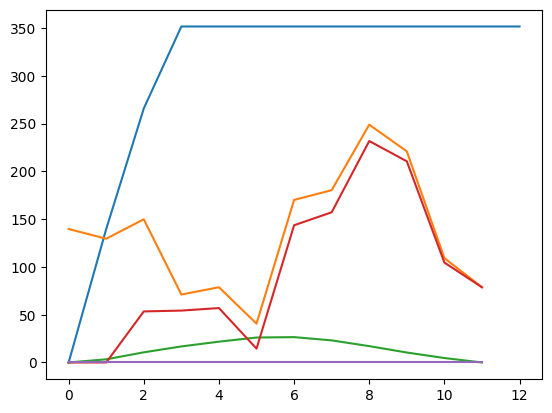

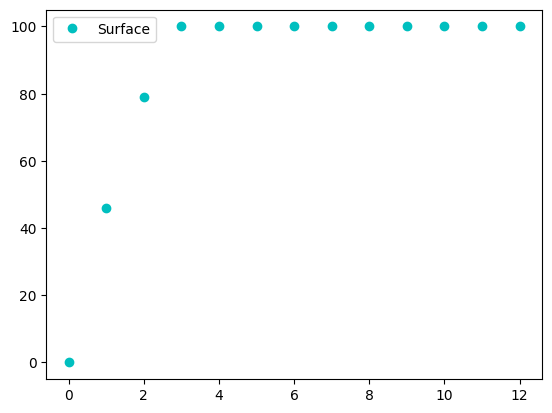

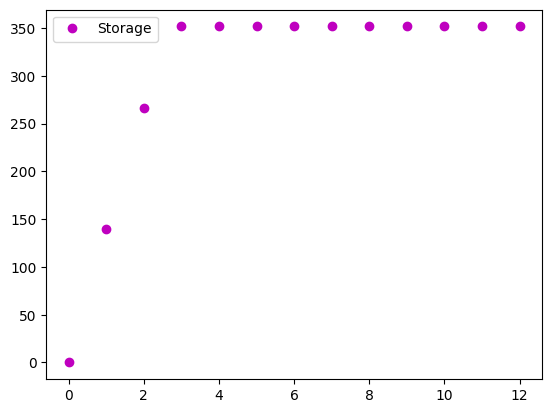

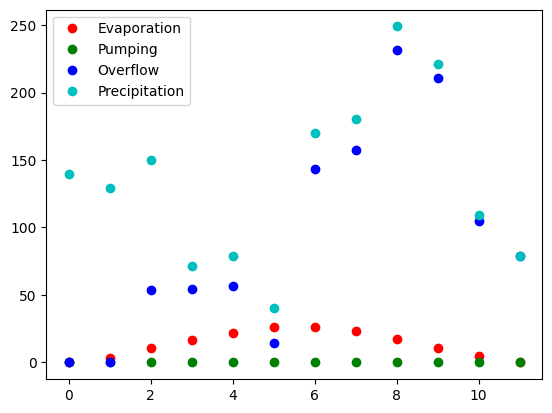

In [5]:
res_storage = [round(instance.S[i].value, ndigits=3) for i in instance.T_points]
res_surface = [round(instance.A[i].value, ndigits=3) for i in instance.T_points]

print(instance.R)
# res_rainfall = [instance.R[i].value for i in instance.T_intervals]
res_evaporation = [round(instance.E[i].value, ndigits=3) for i in instance.T_intervals]
res_pumping = [round(instance.Q[i].value, ndigits=3) for i in instance.T_intervals]
res_overflow = [round(instance.W[i].value, ndigits=3) for i in instance.T_intervals]
res_precipitations = [round(instance.R[i], ndigits=3) for i in instance.T_intervals]

print("Storage", res_storage)
print("Surface", res_surface)
print("Evaporation", res_evaporation)
print("Pumping", res_pumping)
print("Overflow", res_overflow)
print("Precipitation", res_precipitations)

plt.plot(res_storage)
plt.plot(res_precipitations)
plt.plot(res_evaporation)
plt.plot(res_overflow)
plt.plot(res_pumping)
plt.show()

plt.plot(res_surface, "co", label="Surface")
plt.legend()
plt.show()

plt.plot(res_storage, "mo", label="Storage")
plt.legend()
plt.show()

plt.plot(res_evaporation, "ro", label="Evaporation")
plt.plot(res_pumping, "go", label="Pumping")
plt.plot(res_overflow, "bo", label="Overflow")
plt.plot(res_precipitations, "co", label="Precipitation")
plt.legend()
plt.show()